# Graph evaluation report
- Academic Year: 2019/20
- Faculty of Computing - Artificial Intelligence - Semester 2
- Full name and student id: Kacper Trębacz 145453
- Subject: Algorithms and Data Structures


This exercise consinst of two parts:
- evaluation different graph representations in terms of peformance when searching for an existance of an edge between 2 vertices
- determining best representation for topoligical order sorting and evaluate the time needed to perform it

In [62]:
from random import randint,sample, randrange
import sys
import matplotlib.pyplot as plt
import numpy as np
import time 
import math
import random
import string
import copy
import pandas as pd
import json
import os
import multiprocessing as mp
import psutil 
import itertools
plt.rcParams['figure.figsize'] = (10.0, 6.0)
import warnings
warnings.filterwarnings('ignore')

## Constants declaration

In [2]:
BRUTE_FORCE = "BRUTE_FORCE"
SORT_BY_RATIO = "SORT_BY_RATIO"
DYNAMIC = "DYNAMIC"

# Part 1

Firstly, we generate graphs with saturation factor 0.6 and save them to text files. There are 21 graphs of size from 2 to 2002 and 21 graphs of size from 2 to 202

In [3]:
def generate_knapsack_problem(n):
    return [[i for i in range(n)],[randint(1,20) for i in range(n)],[randint(1,20) for i in range(n)]]

# Algorithms definition

# Brute Force

In [4]:
def find_by_brute_force(ids,weights, values, max_weight):
    n = len(ids)
    best_value = 0
    best_value_ids =[]
    for l in range(n+1):
        for p in itertools.combinations(ids,l):
            if sum([weights[i] for i in p]) <= max_weight:
                sum_of_values = sum([values[i] for i in p])
                if sum_of_values > best_value:
                    best_value = sum_of_values
                    best_value_ids = p
    return (best_value,best_value_ids)

# Sort By Ratio

In [5]:
def find_by_ratio(ids, weights, values, max_weight):
    ids = sorted(ids,key=lambda id:values[id]/weights[id],reverse=True)
    chosen_ids=[]
    sum_w=0
    for i in range(len(ids)):
        if sum_w + weights[ids[i]] <= max_weight:
            sum_w+=weights[ids[i]]
            chosen_ids.append(ids[i])
    best_value = sum([values[j] for j in chosen_ids])
    return (best_value, chosen_ids)


# Dynamic Algorithm

In [6]:
def find_with_dynamic(ids, weights, values, max_weight):
    n=len(ids)
    DP = np.zeros((n+1,max_weight+1))
    for i in range(1,n+1):
        for l in range(1,max_weight+1):
            if l < weights[i-1]:
                DP[i][l] = DP[i-1][l]
            else:
                DP[i][l] = max(DP[i-1][l], DP[i-1][l-weights[i-1]]+values[i-1])
    chosen_ids = []
    smallest_i = n
    cur_l = max_weight
    while smallest_i > 0 and cur_l > 0 and DP[smallest_i][cur_l]>0:
        while DP[smallest_i-1][cur_l] == DP[smallest_i][cur_l]:
            smallest_i-=1
        chosen_ids.append(smallest_i-1)
        cur_l-=weights[smallest_i-1]
        smallest_i-=1
    return (DP[n][max_weight],chosen_ids)

In [9]:
ALGORITHMS_DICT = {
    BRUTE_FORCE: find_by_brute_force,
    SORT_BY_RATIO: find_by_ratio,
    DYNAMIC: find_with_dynamic
}

Here we delacre functions which convert graphs from text files to a given representation. We also define functions for each reporesentation that check if a given edge exists in graph.

In [10]:
def plot_plot(X,Ys,labels,title):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel('Time (s)')
    plt.title(title)
    plt.show()
    plt.close()

def measure_time_single_entry(entry, knapsack_set):
    knapsack_solver = ALGORITHMS_DICT[entry]
    max_w = int(sum(knapsack_set[1])/2)
    start_time = time.time()
    knapsack_solver(knapsack_set[0],knapsack_set[1],knapsack_set[2],max_w)
    return time.time()-start_time

def perform_test_single_entry(entry, knapsack_sets):
    return [measure_time_single_entry(entry,knapsack_set) for knapsack_set in knapsack_sets]

def perform_tests(entries,minimum=1,maximum=11,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    knapsack_sets = [generate_knapsack_problem(x) for x in X]
    Ys = [perform_test_single_entry(entry,knapsack_sets) for entry in entries]
    plot_plot(X, Ys, entries, "Time of finding sollutions")
    plt.yscale("log")
    plot_plot(X, Ys, entries, "Time of finding sollutions log scale")

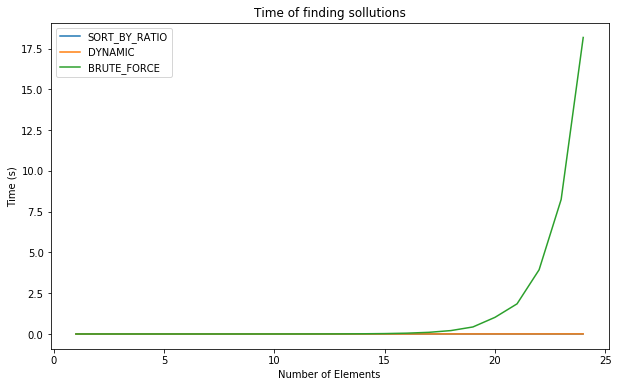

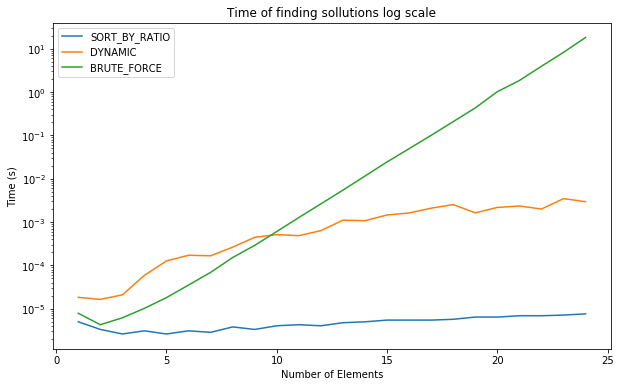

In [66]:
perform_tests([SORT_BY_RATIO,DYNAMIC,BRUTE_FORCE],1,25)

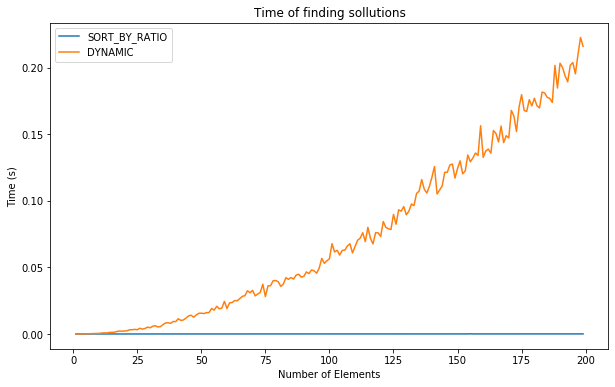

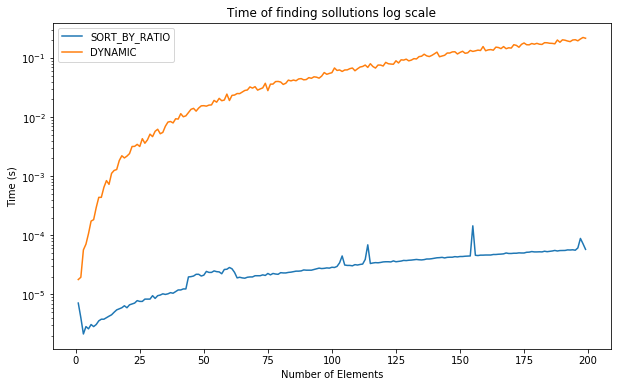

In [12]:
perform_tests([SORT_BY_RATIO,DYNAMIC],1,200)

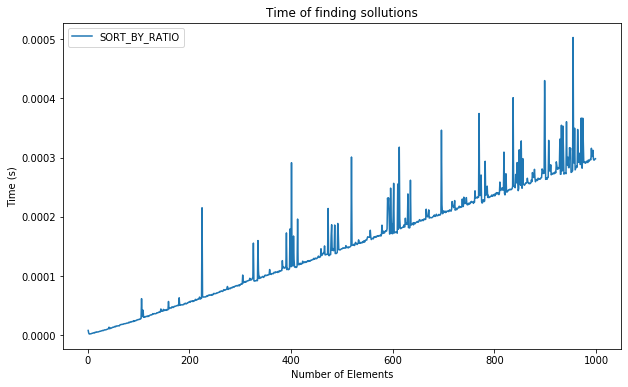

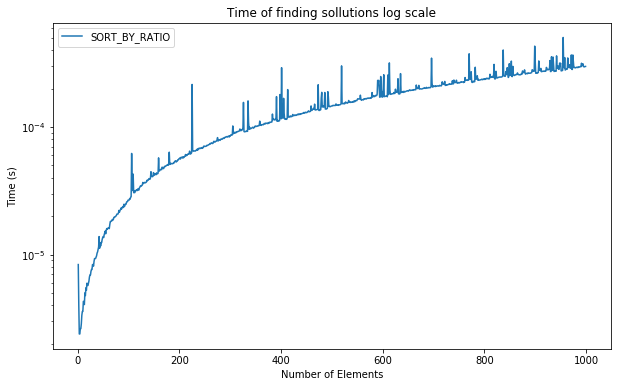

In [13]:
perform_tests([SORT_BY_RATIO],1,1000)

In [60]:
RETRIES = 10
def plot_plot_score(X,Ys,labels,title, y_label):
    for i in range(len(Ys)):
        plt.plot(X,Ys[i],label=str(labels[i]))
    plt.legend()
    plt.xlabel('Number of Elements')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def measure_score_single_entry(entry, knapsack_set):
    knapsack_solver = ALGORITHMS_DICT[entry]
    results = [knapsack_solver(knapsack_set[i][0],knapsack_set[i][1],knapsack_set[i][2], int(sum(knapsack_set[i][1])/2))[0] for i in range(RETRIES)]
    return sum(results)/RETRIES

def perform_test_single_entry_score(entry, knapsack_sets):
    pool = mp.Pool(psutil.cpu_count(logical=False))
    results = pool.starmap(measure_score_single_entry,[(entry,knapsack_set) for knapsack_set in knapsack_sets])
    pool.terminate()
    return results

def perform_tests_score(entries,minimum=1,maximum=11,jump=1):
    X = [i for i in range(minimum,maximum, jump)]
    knapsack_sets = [[generate_knapsack_problem(x) for i in range(RETRIES)] for x in X]
    print("done generating")
    Ys = [perform_test_single_entry_score(entry,knapsack_sets) for entry in entries]
    plot_plot_score(X, Ys, entries, "Quality Comparison",'Best Value')
    MSE = 0
    Y = [(Ys[1][i]-Ys[0][i])/Ys[1][i]*100 for i in range(len(X))]
    plot_plot_score(X,[Y],["Difference"], "Quality Comparison","Difference in Value(%)")


done generating


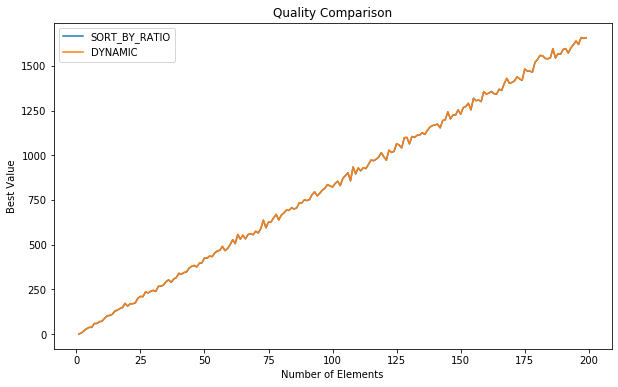

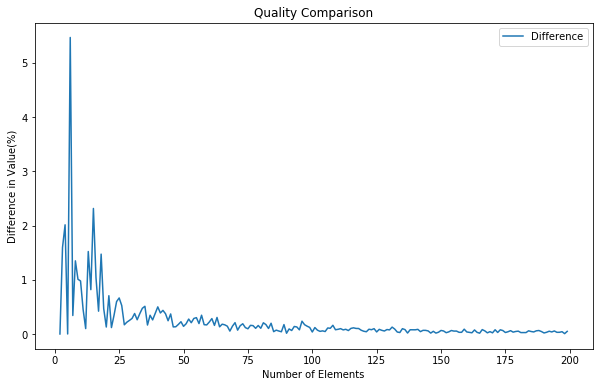

In [63]:
perform_tests_score([SORT_BY_RATIO,DYNAMIC],1,200,1)